<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "2C"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/DissectionRegions/2C/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


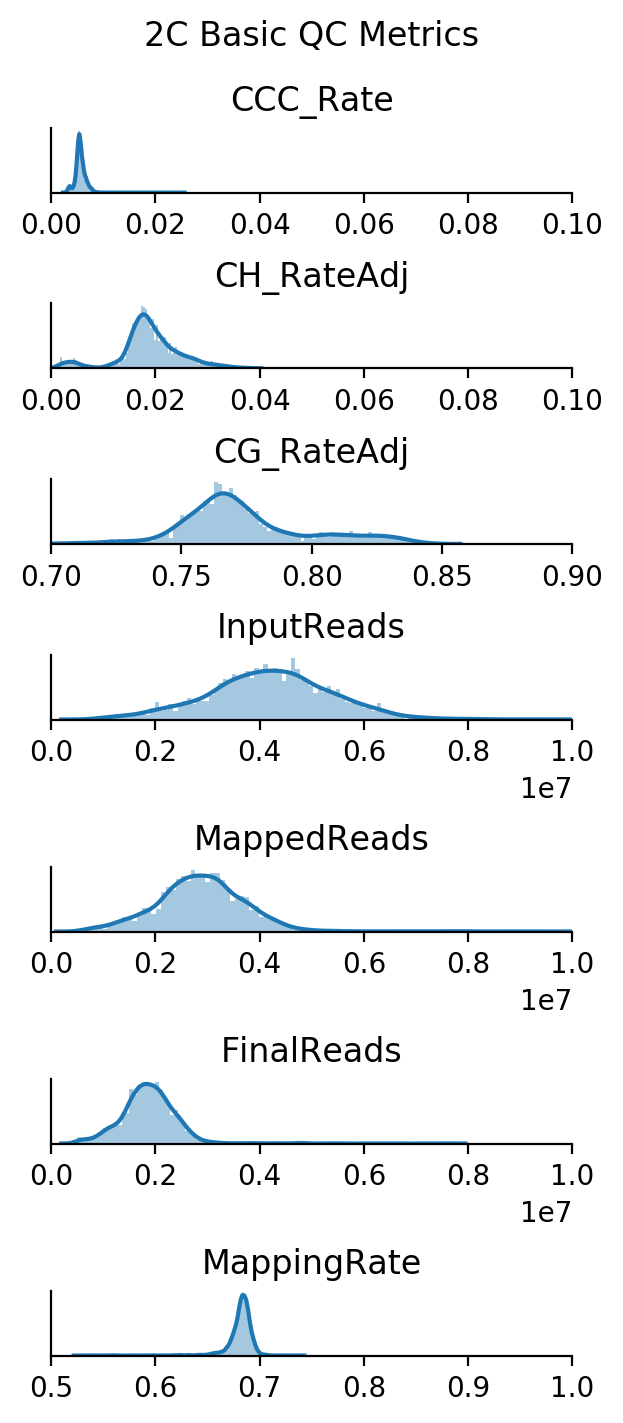

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

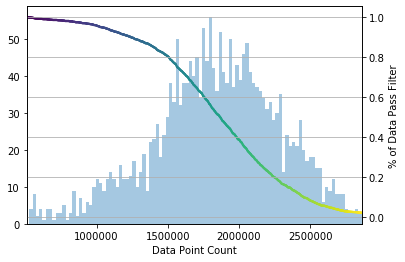

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 2148/2148 (100.0%)
CG_RateAdj passed 2148/2148 (100.0%)
CH_RateAdj passed 2148/2148 (100.0%)
FinalReads passed 2148/2148 (100.0%)
MappingRate passed 2148/2148 (100.0%)
Overall passed 2148/2148 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
180409 1144
180410 1004


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 261 68.0%
ad002 269 70.1%
ad004 237 61.7%
ad006 241 62.8%
ad007 287 74.7%
ad008 284 74.0%
ad010 288 75.0%
ad012 281 73.2%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,SubType,l3-umap_0,l3-umap_1,l3-tsne_0,l3-tsne_1,PassFilter
2C_M_0,/gale/raidix/rdx-4/CEMBA_RS1/2C/CEMBA180409_2C...,0.00511,0.77073,0.76955,0.02154,0.01651,1076259.0,2314862,1517338.0,2C,...,5.084980,-15.586631,-35.067517,5.053515,IT-L4 Shc3,-1.536056,0.012656,-9.481938,15.043767,True
2C_M_1,/gale/raidix/rdx-4/CEMBA_RS1/2C/CEMBA180409_2C...,0.00531,0.75683,0.75553,0.02196,0.01674,1197092.0,2590626,1709334.0,2C,...,-2.010863,-10.386750,-25.873014,44.089235,IT-L23 Cux1,5.303115,4.721660,30.498178,7.663859,True
2C_M_10,/gale/raidix/rdx-4/CEMBA_RS1/2C/CEMBA180409_2C...,0.00581,0.75720,0.75578,0.02603,0.02034,1006630.0,2348484,1606410.0,2C,...,10.127059,-13.930543,15.257140,27.713219,IT-L5 Etv1,6.281672,8.499489,-17.768726,-12.128536,True
2C_M_100,/gale/raidix/rdx-4/CEMBA_RS1/2C/CEMBA180409_2C...,0.00634,0.74984,0.74824,0.02718,0.02097,2026078.0,4599922,3154619.0,2C,...,-0.403330,-12.645478,-12.533070,41.509914,IT-L23 Cux1,0.289810,6.388457,12.181118,-10.716913,True
2C_M_1000,/gale/raidix/rdx-4/CEMBA_RS1/2C/CEMBA180409_2C...,0.00521,0.77073,0.76953,0.02117,0.01604,2368464.0,5320502,3648786.0,2C,...,-2.592444,-9.669762,-29.123013,44.001800,IT-L23 Cux1,5.873048,4.384917,32.871071,9.984598,True
2C_M_1001,/gale/raidix/rdx-4/CEMBA_RS1/2C/CEMBA180409_2C...,0.00518,0.76248,0.76124,0.02294,0.01785,1909588.0,4259662,2952951.0,2C,...,-0.603772,-11.961258,-12.739861,42.008451,IT-L23 Cux1,1.034755,6.071552,14.351680,-7.991735,True
2C_M_1002,/gale/raidix/rdx-4/CEMBA_RS1/2C/CEMBA180409_2C...,0.00551,0.77645,0.77521,0.02297,0.01756,2051219.0,4645026,3194478.0,2C,...,0.434702,-12.068789,-8.900272,40.310313,IT-L23 Cux1,-0.192869,5.701999,8.599657,-9.172050,True
2C_M_1003,/gale/raidix/rdx-4/CEMBA_RS1/2C/CEMBA180409_2C...,0.00499,0.77449,0.77336,0.01992,0.01500,2052755.0,4610422,3198524.0,2C,...,-26.202351,-19.469036,3.952133,-61.218198,CGE-Lamp5 Grk5,3.513026,10.450252,-11.958945,18.688890,True
2C_M_1004,/gale/raidix/rdx-4/CEMBA_RS1/2C/CEMBA180409_2C...,0.00577,0.76627,0.76491,0.02338,0.01771,2157993.0,4817386,3363372.0,2C,...,-2.092429,-10.386051,-25.416396,43.911870,IT-L23 Cux1,4.555067,5.032878,28.869817,4.658653,True
2C_M_1005,/gale/raidix/rdx-4/CEMBA_RS1/2C/CEMBA180409_2C...,0.00536,0.75600,0.75469,0.02366,0.01840,2284491.0,5050462,3466674.0,2C,...,0.030265,-13.788523,-7.475657,44.254861,IT-L23 Cux1,-1.558498,8.803711,5.789001,-35.174253,True
